# Draw figure

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../')
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from loader.synthetic import sample2d
from models.mpdr import MPDR_Single, AE

from models.modules import FCNet
from ipywidgets import Output
from IPython.display import clear_output

from models.mmd import mmd

In [2]:
dset = '8gaussians'
xmin, xmax, ymin, ymax = [-4, 4, -4, 4]
batch_size = 200
device = 'cuda:1'

In [3]:
XX, YY = torch.meshgrid(torch.linspace(xmin, xmax, 100), torch.linspace(ymin,ymax, 100))
grid = torch.cat([XX.reshape(-1,1), YY.reshape(-1,1)], dim=1)
grid_gpu = grid.to(device)

/opt/conda/envs/nae/lib/python3.8/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(1., dtype=torch.float64)


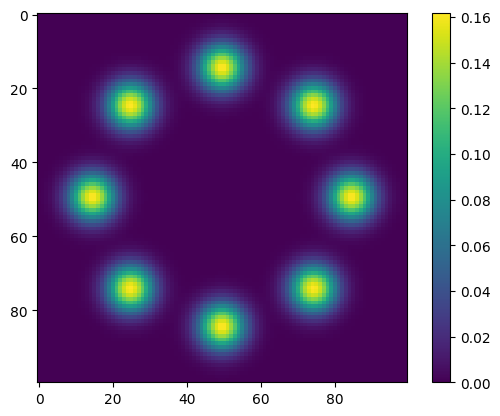

In [4]:
'''compute 8 gaussains pdf normalized in (4,-4)'''
from loader.synthetic import pdf_8gaussian
p_8gaussian = pdf_8gaussian(grid)
p_8gaussian /= (p_8gaussian * (8/100 * 8 / 100)).sum()
print((p_8gaussian * (8/100 * 8 / 100)).sum())

p_8gaussian = p_8gaussian.reshape(100,100)

plt.imshow(p_8gaussian)
plt.colorbar()

In [5]:
xx = sample2d(dset, batch_size=batch_size)

## Procedure Figure

In [6]:
zdim = 2
encoder = FCNet(in_dim=2, out_dim=zdim, l_hidden=[128, 128], out_activation='linear', activation='relu')
decoder = FCNet(in_dim=zdim, out_dim=2, l_hidden=[128, 128], out_activation='linear', activation='relu')

ae = AE(encoder, decoder, l2_norm_reg_enc=None, encoding_noise=None, spherical=True)

varnet_x = FCNet(in_dim=2, out_dim=1, l_hidden=[256, 256, 256], out_activation='linear', activation='relu', use_spectral_norm=True, learn_out_scale=True)

model = MPDR_Single(ae=ae, net_x=varnet_x,
                sampling_x='langevin',
                mcmc_n_step_x=10, mcmc_stepsize_x=1., mcmc_noise_x =0.15, mh_x=False,
                mcmc_n_step_omi=2, mcmc_stepsize_omi=0.1, mcmc_noise_omi=0.02, mcmc_normalize_omi=True,
                gamma_vx=1.,
                temperature=1., 
                proj_mode='uniform', proj_noise_start=0.05, proj_noise_end=0.3, proj_const=0.0001,
                 z_dim =zdim,
                )
model.eval();

In [7]:
model.load_state_dict(torch.load('mpdr_scalar_z2_8gaussian.pth'))

<All keys matched successfully>

In [8]:
theta = torch.linspace(-np.pi, np.pi, 100)
z = torch.stack([torch.cos(theta), torch.sin(theta)]).T

In [9]:
manifold = model.ae.decoder(z).detach()

In [10]:
xx = torch.tensor(xx)

In [11]:
proj_noise = model.get_proj_noise(xx)
xx_perturbed, z = model.ae.project_diffuse(xx, proj_noise)
xx_perturbed = xx_perturbed.detach()

In [12]:
d_omi = model.on_manifold_init_v2(xx_perturbed, z, proj_noise)

In [13]:
xx_omi = d_omi['x_init'].detach()

In [14]:
d_sample = model.p_sample_langevin_off_v2(ae=model.ae, x_init=xx_omi, z_obs=z, proj_noise=proj_noise)

In [15]:
d_sample.keys()

dict_keys(['sample', 'l_grad_y', 'l_sample', 'mcmc_n_step_x', 'd_sample', 'avg_grad_norm'])

In [16]:
xx_sample = d_sample['sample'].detach()

In [17]:
plt.rcParams.update({'font.size': 20})

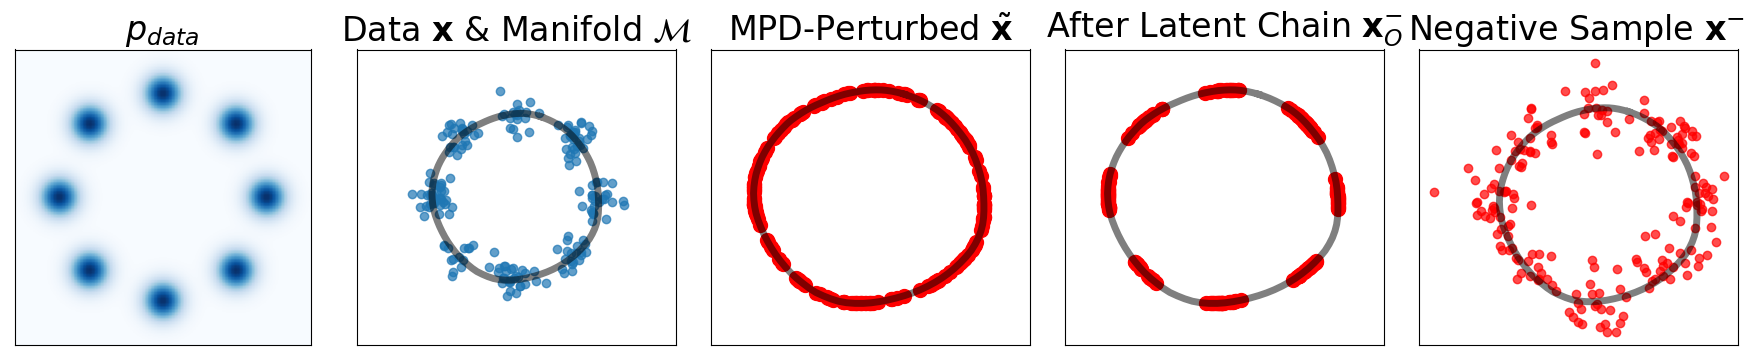

In [18]:
fig, axs = plt.subplots(ncols=5, figsize=(18,4))
ax = axs[0]
ax.imshow(p_8gaussian, extent=(-4,4,-4,4), cmap='Blues')
# axs[0].axis('off');
ax.set_title('$p_{data}$')
ax.set_xticks([])
ax.set_yticks([])

ax = axs[1]
ax.plot(manifold[:,0], manifold[:,1], 'k-', alpha=0.5, linewidth=5)
ax.scatter(xx[:,0], xx[:,1], alpha=0.7)
ax.axis('equal')
ax.set_title('Data $\\mathbf{x}$ & Manifold $\\mathcal{M}$')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([-4,4]); ax.set_ylim([-4,4])
# ax.axis('off')

ax = axs[2]
ax.set_title('MPD-Perturbed $\\tilde\\mathbf{x}$')

ax.plot(manifold[:,0], manifold[:,1], 'k-', alpha=0.5, linewidth=5)
# ax.axis('equal')
ax.scatter(xx_perturbed[:,0], xx_perturbed[:,1], c='r', s=100)
ax.set_xlim([-4,4]); ax.set_ylim([-4,4])
ax.set_xticks([])
ax.set_yticks([])

ax = axs[3]
ax.set_title('After Latent Chain $\\mathbf{x}^{-}_O$')
ax.plot(manifold[:,0], manifold[:,1], 'k-', alpha=0.5, linewidth=5)
ax.scatter(xx_omi[:,0], xx_omi[:,1], c='r', s=100)
ax.set_xlim([-4,4]); ax.set_ylim([-4,4])
ax.set_xticks([])
ax.set_yticks([])

ax = axs[4]
ax.set_title('Negative Sample $\\mathbf{x}^{-}$ ')
ax.plot(manifold[:,0], manifold[:,1], 'k-', alpha=0.5, linewidth=5)
ax.scatter(xx_sample[:,0], xx_sample[:,1], c='r', alpha=0.7)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
# plt.savefig('fig_mpdr_procedure.pdf', bbox_inches='tight', dpi=500)

## Scalar vs AE Figure

In [111]:
p_scalar = torch.load('p_theta_mpdr_scalar_8gaussian.pkl')
p_ae = torch.load('p_theta_mpdr_ae_hybrid_8gaussian.pkl')

In [135]:
E_scalar = torch.load('E_mpdr_scalar_8gaussian.pkl')
E_ae = torch.load('E_mpdr_ae_hybrid_8gaussian.pkl')

[]

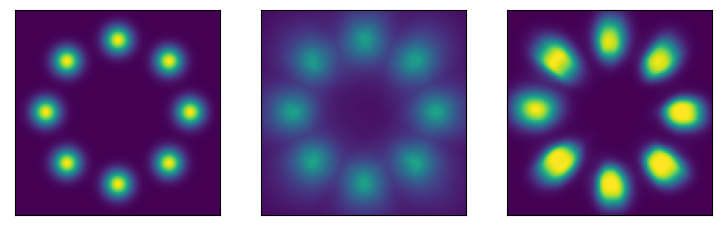

In [138]:
fig, axs = plt.subplots(ncols=3, figsize=(9, 4))
ax = axs[0]
ax.imshow(p_8gaussian, vmin=0, vmax=p_8gaussian.max())
ax.set_xticks([])
ax.set_yticks([])
ax = axs[1]
ax.imshow(p_scalar, vmin=0, vmax=p_ae.max())
ax.set_xticks([])
ax.set_yticks([])
ax = axs[2]
ax.imshow(p_ae, vmin=0, vmax=p_ae.max())
ax.set_xticks([])
ax.set_yticks([])

In [148]:
plt.rcParams.update({'font.size': 18})

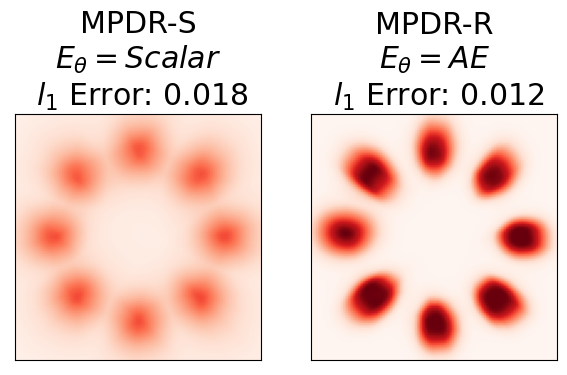

In [157]:
fig, axs = plt.subplots(ncols=2, figsize=(7, 4))
# axs[0].imshow(p_8gaussian, vmin=0, vmax=p_8gaussian.max(), cmap='Blues')
# axs[0].set_xticks([])
# axs[0].set_yticks([])
# axs[0].set_title('$p_{data}$')

T = 0.5
Omega = ((8 / 100 * 8 / 100) * np.exp(-E_scalar / T)).sum()
p_scalar = np.exp(-E_scalar / T) / Omega


Omega = ((8 / 100 * 8 / 100) * np.exp(-E_ae / T)).sum()
p_ae = np.exp(-E_ae / T) / Omega

axs[0].imshow(p_scalar, vmin=0, vmax=p_ae.max(), cmap='Reds')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('MPDR-S\n$E_{\\theta}=Scalar$\n $l_1$ Error: 0.018')
axs[1].imshow(p_ae, vmin=0, vmax=p_ae.max(), cmap='Reds')
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('MPDR-R\n$E_{\\theta}=AE$\n $l_1$ Error: 0.012')
plt.savefig('fig_2d_estimation.pdf', bbox_inches='tight', dpi=500)